In [1]:
# !pip install pydot
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model

import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt

In [2]:
class earlyStop(tf.keras.callbacks.Callback):
    def on_epoch_end(self,epochs,logs={}):
        if logs.get("vall_acc") > 0.95:
            print("Val Accuracy is greater than 0.95, stopping training")
            self.model.stop_training = True

In [3]:
data_path = './archive/asl_alphabet_train/asl_alphabet_train/'
log_dir = "logs_cnn/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
earlyStopping = earlyStop()
save_best = tf.keras.callbacks.ModelCheckpoint(filepath="cnn.h5",save_weights_only=False,monitor="val_accuracy", mode="max", save_best_only=True)

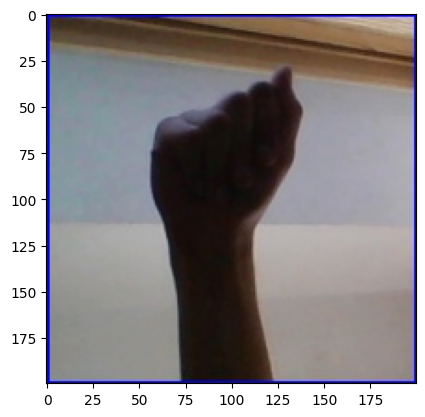

In [4]:
img = image.load_img('archive/asl_alphabet_train/asl_alphabet_train/A/A1.jpg')
plt.imshow(img)

In [5]:
t_data = image.ImageDataGenerator(rescale=1./255,rotation_range=20,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    fill_mode='nearest')

v_data = image.ImageDataGenerator(rescale=1./255)

train_datagen = t_data.flow_from_directory(data_path,
                                            target_size=(128,128),
                                            batch_size=64)
val_datagen = v_data.flow_from_directory(data_path,
                                            target_size=(128,128),
                                            batch_size=64)

Found 87000 images belonging to 29 classes.
Found 87000 images belonging to 29 classes.


In [6]:
def CNN_model(inp_shape,output_shape):
    inputs = layers.Input(shape=inp_shape)

    x = layers.BatchNormalization()(inputs)
    x = layers.Conv2D(16,(3,3),strides=1,padding='same')(x)
    x = layers.ReLU()(x)

    # Block 1
    x = layers.Conv2D(16,(3,3),strides=1,padding='same')(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(16,(3,3),strides=1,padding='same')(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(16,(3,3),strides=1,padding='same')(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(16,(3,3),strides=1,padding='same')(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(32,(3,3),strides=2,padding='same')(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(32,(3,3),strides=1,padding='same')(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(32,(1,1),strides=2,padding='same')(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(32,(3,3),strides=1,padding='same')(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(32,(3,3),strides=1,padding='same')(x)
    x = layers.ReLU()(x)

    x = layers.AveragePooling2D()(x)
    x = layers.Flatten()(x)
    output = layers.Dense(output_shape,activation='softmax')(x)

    model = tf.keras.models.Model(inputs,output)
    return model

In [7]:
model = CNN_model(inp_shape=(128,128,3),output_shape=29)

In [8]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 3)      12        
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 re_lu (ReLU)                (None, 128, 128, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 16)      2320      
                                                                 
 re_lu_1 (ReLU)              (None, 128, 128, 16)      0         
                                                             

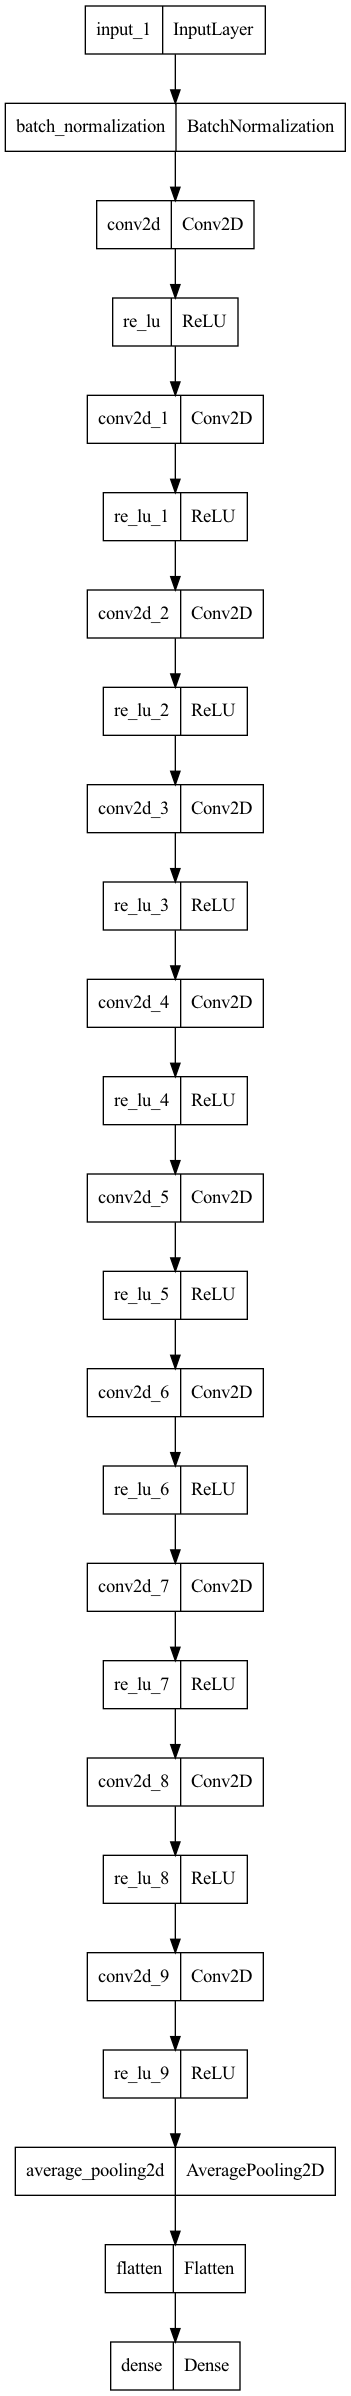

In [9]:
# Uncomment to save a visualization of the model architecture
plot_model(model,to_file="cnn_connection.png")#, show_shapes=True,show_layer_names=True)

In [10]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics='accuracy')

In [11]:
history = model.fit(train_datagen, 
            epochs=5,
            validation_data=val_datagen,
            callbacks=[tensorboard_callback,save_best])

Epoch 1/5


2022-09-29 02:08:50.725547: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1360/1360 [==============================] - 1591s 1s/step - loss: 1.6984 - accuracy: 0.4959 - val_loss: 0.2997 - val_accuracy: 0.9019
Epoch 2/5
1360/1360 [==============================] - 1617s 1s/step - loss: 0.5283 - accuracy: 0.8340 - val_loss: 0.1889 - val_accuracy: 0.9365
Epoch 3/5
1360/1360 [==============================] - 20321s 15s/step - loss: 0.3681 - accuracy: 0.8832 - val_loss: 0.1285 - val_accuracy: 0.9579
Epoch 4/5
1360/1360 [==============================] - 2122s 2s/step - loss: 0.2864 - accuracy: 0.9087 - val_loss: 0.0548 - val_accuracy: 0.9838
Epoch 5/5
1360/1360 [==============================] - 1286s 945ms/step - loss: 0.2452 - accuracy: 0.9228 - val_loss: 0.0966 - val_accuracy: 0.9691


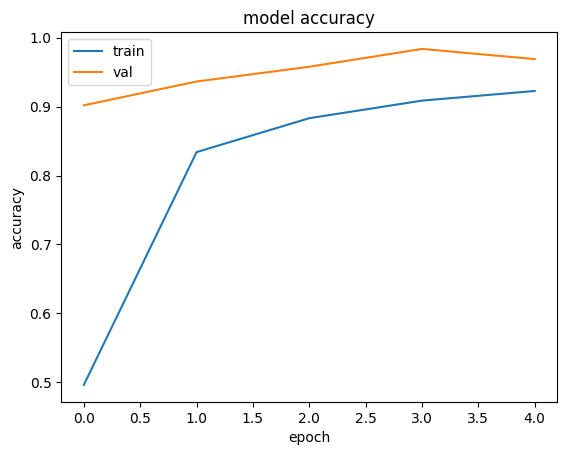

<Figure size 640x480 with 0 Axes>

In [16]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.savefig('cnn_accuracy_plot.png')

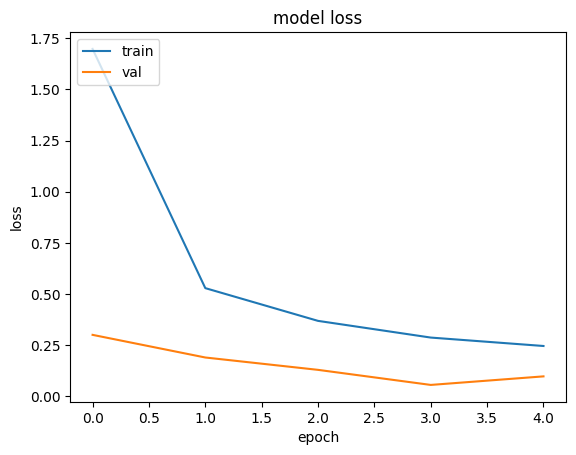

<Figure size 640x480 with 0 Axes>

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.savefig('cnn_loss_plot.png')